# Exploratory Data Analysis - Inferential Statistics

In [1]:
import pyspark
from pyspark.sql import SparkSession

import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, split
from pyspark.sql.functions import array_contains

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datetime


import json
import nltk
from nltk.tokenize import word_tokenize

import collections
from collections import Counter

from scipy.stats import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest

import re



%matplotlib inline

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
fastFoodDF = spark.read.json('../SavedFiles/fastFood.json')

In [4]:
fastFoodPDF = fastFoodDF.toPandas()

In [5]:
fastFoodPDF.shape

(220507, 10)

In [6]:
fastFoodPDF.head()

,business_id,city,date,name,review_id,stars,state,text,useful,word_count
0,lYv2-FaGQBhZnVxTb3Qc5Q,Las Vegas,2012-04-05 01:45:36,Wendy's,Ieq-XKnp5BrK95VuvXNouQ,1.0,NV,PLEASE AVOID THIS PLACE.\nstupid dude cant cou...,1,28
1,aZOoc-87ESqy8apJO3J-Yw,Gilbert,2017-05-28 23:01:26,Slim Chickens,ZbFJnkkPQ_fiUw0FJKzLbg,5.0,AZ,What a welcome concept in fast food. Cute pla...,0,83
2,dKdApYVFDSNYsNOso6NYlA,Las Vegas,2017-01-07 05:43:47,White Castle,xYmddD9LEtZSoPK0x7u52w,3.0,NV,Been wanting to try this place since everyone ...,1,116
3,KpfCj839-MPcxM8FKkW7GA,Pittsburgh,2012-10-18 19:31:19,Taco Bell,wVoXYLxYIO_JsiPQFl7E7w,3.0,PA,Stopped here because I finally had to try the ...,1,153
4,KCIVWrtbeIlLpzRJWxJz4g,Toronto,2017-07-21 17:22:22,McDonalds,ZaAVeAOF2S1PYIsg7sjJyQ,1.0,ON,"Everytime I go to this spot for ice cream, I w...",0,81


## Question 1: Do people from the USA rate fast food establishments differently than Canadians do?

HYPOTHESIS TEST: <br>
Null hypothesis: The average star-rating of fast food establishments is the same in the USA and in Canada. <br>
$H_0$: $\mu_{usa}$ = $\mu_{can}$ <br>
Alternate hypothesis: There is a statistically significant difference in star-ratings of fast food restaurants in the USA and Canada. <br>
$H_A$: $\mu_{usa}$ $\neq$ $\mu_{can}$ <br>
$\alpha$ = 0.01

In [7]:
fastFoodPDF['state'].unique()

array(['NV', 'AZ', 'PA', 'ON', 'OH', 'WI', 'NC', 'IL', 'QC', 'AB', 'SC',
       'FL', 'AR', 'NY', 'BC'], dtype=object)

In [8]:
def which_country(state):
    provinces = ['ON', 'QC', 'AB', 'BC']
    if state in provinces:
        country = 'CAN'
    else:
        country = 'USA'
    return country

In [9]:
fastFoodPDF['country'] = fastFoodPDF['state'].apply(which_country)

In [10]:
fastFoodPDF.groupby('country')['stars'].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CAN,29284.0,3.337932,1.372547,1.0,2.0,4.0,4.0,5.0
USA,191223.0,3.150453,1.604099,1.0,1.0,3.0,5.0,5.0


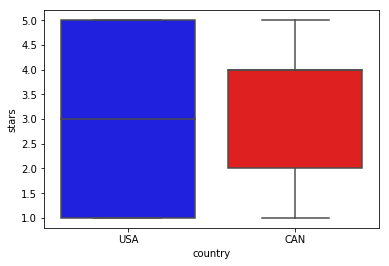

In [11]:
sns.boxplot(x='country', y='stars', data=fastFoodPDF, palette=['blue', 'red'])

The above summary statistics show that there were 29,284 Canadian fast food restaurants reviewed and 191,223 US fast food restaurants reviewed.  The average rating in Canada (3.338) was 0.188 stars higher than in the US (3.15).  We also see visually boxplots that there is less spread in Canada. I was a bit surprised to observe a higher average rating of fat food restaurants in Canada because the US has a reputation for loving fast food.  However, it is possible that Canadian fast food establishments are of higher quality. <br>
Let's see if the observed difference is statistically significant...

In [12]:
ratingUSA = fastFoodPDF[fastFoodPDF.country=='USA'].stars
ratingCAN = fastFoodPDF[fastFoodPDF.country=='CAN'].stars

test_stat = np.mean(ratingUSA) - np.mean(ratingCAN)

#frequentist approach
std_dev_diff = np.sqrt((np.std(ratingUSA)/len(ratingCAN))+(np.std(ratingUSA)/len(ratingCAN)))

z_star = norm.ppf(0.995)


moe = z_star * std_dev_diff
conf_int = (test_stat-moe, test_stat+moe)
print('Observed Diff in Means: ', test_stat)
print('Margin of error: ', moe)
print('99% confidence interval: ', conf_int)

Observed Diff in Means:  -0.1874793635880394
Margin of error:  0.026960741588325527
99% confidence interval:  (-0.21444010517636494, -0.16051862199971387)


We are 99% confident that the average rating of fast food restaurants in the US is between 0.16 and 0.21 stars lower than in Canada. Since 0 does not fall within the confidence interval we can reject the null hypothesis and conclude that there is a statistically significant difference in average rating in US and Canada.

In [13]:
#two-sided, two-sample hypothesis test
z, p_z = ztest(ratingUSA, ratingCAN, alternative = 'two-sided')

print('z-score: ', z)
print('p-value: ', p_z)

z-score:  -18.96538288270543
p-value:  3.296184668321536e-80


Similarly, the p-value is very low, much smaller than the significance level of 0.01, so we can reject the null hypothesis.  We should keep in mind that the sample size is very large, which may be a reason we are seeing such a low p-value.

## Question 2: Is there a correlation between the word count of reviews and the number of helpful votes?

HYPOTHESIS TEST: <br>
Null hypothesis: There is no correlation between the word count of the reviews and the number of useful votes. <br>
$H_{0}$: $\rho$ = 0 <br>
Alt. hypothesis: There is a correlation between the word count and the number of useful votes. <br>
$H_{A}$: $\rho$ $\neq$ 0 <br>
$\alpha$ = 0.01 <br>

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(25.0, 0.5, '# of Useful Votes')

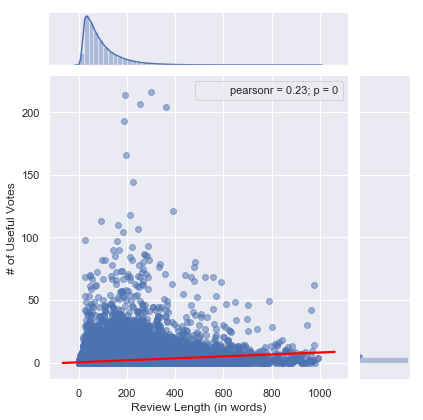

In [14]:
sns.set()

jplot = sns.jointplot('word_count', 'useful', data = fastFoodPDF, kind = 'reg', scatter_kws = {'alpha': 0.5}, line_kws = {'color':'red'})
jplot.annotate(stats.pearsonr)
plt.xlabel('Review Length (in words)')
plt.ylabel('# of Useful Votes')

In [15]:
obs_corr = np.corrcoef(fastFoodPDF['word_count'], fastFoodPDF['useful'])[0,1]
print('Observed correlation between review length and number of useful votes: ', obs_corr)

perm_reps = np.empty(100000)
for i in range(100000):
    perm_useful = np.random.permutation(fastFoodPDF['useful'])
    perm_reps[i] = np.corrcoef(fastFoodPDF['word_count'], perm_useful)[0,1]

p_value = sum(perm_reps >= obs_corr)/100000    
print('p-value: ', p_value)

Observed correlation between review length and number of useful votes:  0.2324651742708063
p-value:  0.0



Out of 100,000 permutations no permutation resulted in a correlation coefficient as extreme as the observed correlation of 0.232 so the p-value is very low. We can reject the null hypothesis, and conclude thatis a statistically significant correlation. However, the correlation of 0.232 is weak, and again the sample size is large (220,507).

## Question 3: Is there a statistically significant difference  in the length of reviews by star-rating?

HYPOTHESIS TEST: <br>
Null hypothesis: The average word count of 1-star, 2-star, 3-star, and 4-star, and 5-star reviews are all equal. <br>
$H_0$: $\mu_{1star}$ = $\mu_{2star}$ = $\mu_{3star}$ = $\mu_{4star}$ = $\mu_{5star}$ <br>
Alternate hypothesis: The average word length of at least one of the star ratings is not equal to the others. <br>
$\alpha$ = 0.01

In [16]:
fastFoodPDF.groupby('stars')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1.0,56093.0,101.593550,90.467986,0.0,43.0,75.0,128.0,994.0
2.0,24896.0,110.114557,90.533758,1.0,49.0,84.0,142.0,972.0
3.0,28701.0,109.027072,92.066418,1.0,47.0,83.0,142.0,993.0
4.0,45886.0,97.706969,84.294647,2.0,41.0,72.0,127.0,951.0
5.0,64931.0,75.002988,69.843840,1.0,32.0,53.0,92.0,974.0


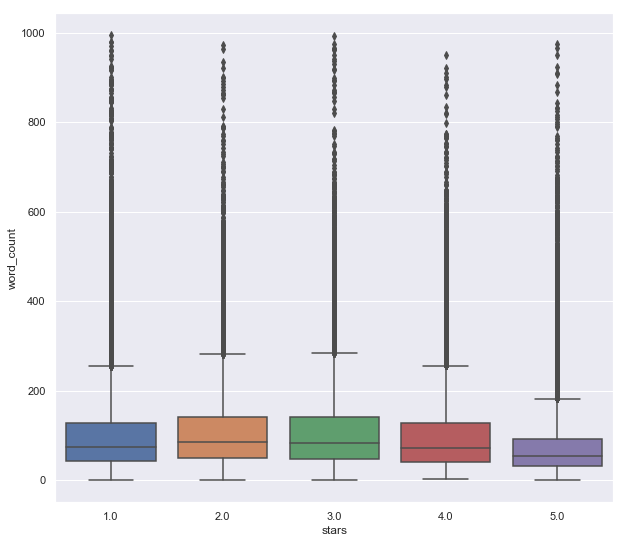

In [17]:
plt.figure(figsize = (10,9))
sns.boxplot(x = 'stars', y = 'word_count', data = fastFoodPDF)
plt.savefig('../SavedFiles/lengthByStar')

From the above box plots and summary statistics, we see that five-star reviews seem to have a lot less spread than the others, and that, overall, the reviews tend to  be shorter.  The two-star and 3-star reviews have the highest average review lengths, 110.11 and 109.02, respectively.  It makes sense that 2-star and 3-star reviews tend to be longer because there may be more to explain if did not have a great time at the restaurant or had a mixed review.

In [18]:
#ANOVA
stats.f_oneway(fastFoodPDF[fastFoodPDF.stars == 1]['word_count'], 
             fastFoodPDF[fastFoodPDF.stars == 2]['word_count'],
             fastFoodPDF[fastFoodPDF.stars == 3]['word_count'],
              fastFoodPDF[fastFoodPDF.stars == 4]['word_count'],
              fastFoodPDF[fastFoodPDF.stars == 5]['word_count'])

F_onewayResult(statistic=1425.8834957820923, pvalue=0.0)

Since the f-statistic is much higher than one, and the p-value is very close to 0, we can reject the null hypothesis and conclude that there is a statistically significant difference in at least one of the star-ratings.

## Question 4: Is the proportion of people who rate Subway positively higher than the proportion of people who give McDonald's positive reviews?
For this we will consider positive reviews to be 4- and 5-star reviews.

In [19]:
#find the most reviewed fast food restaurant/chain in the data set
by_rest = fastFoodPDF.groupby('name')['stars'].count()
by_rest.sort_values(ascending = False).head()

name
McDonald's                14862
Chipotle Mexican Grill     9586
In-N-Out Burger            6919
Subway                     6178
Taco Bell                  5193
Name: stars, dtype: int64


Null hypothesis: There is not a difference in proportion of positive reviews of McDonald's and Subway. <br>
$H_{0}$: $p_{m}$ = $p_{s}$ <br>
Alternate hypothesis: There is a statistically significant difference in the proportion of positive reviews of the two restaurants. <br>
$H_{A}$: $p_{m}$  < $p_{s}$ <br>
$\alpha$ = 0.01

In [20]:
def is_positive(stars):
    if stars in [4,5]:
        pos = 1
    else:
        pos = 0
    return pos   

In [21]:
fastFoodPDF['pos'] = fastFoodPDF['stars'].apply(is_positive)

In [22]:
McD = fastFoodPDF[fastFoodPDF.name == 'McDonald\'s']
Sub = fastFoodPDF[fastFoodPDF.name == 'Subway']

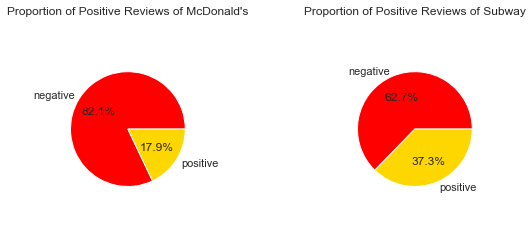

In [23]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.axis('equal')
plt.pie(McD['pos'].value_counts(), colors = ['red','gold'], labels = ['negative','positive'], autopct='%1.1f%%', radius=3)
plt.subplots_adjust(wspace=5)
plt.title('Proportion of Positive Reviews of McDonald\'s')


fig.add_subplot(1,2,2)
plt.axis('equal')
plt.pie(Sub['pos'].value_counts(), colors = ['red','gold'], labels = ['negative', 'positive'], autopct='%1.1f%%', radius=3)
plt.title('Proportion of Positive Reviews of Subway')

plt.savefig('../SavedFiles/McDSubPie')

From the above pie charts that the proportion of positive reviews was 2 times higher than that of McDonald's.  I am a bit surprised to see such a big difference because McDonald's is so popular, so I would expect to see more than 17.9% positive reviews.  However, it makes sense now that McDonald's appeared in the word clous for 1-star reviews.

In [24]:
p_mcd_pos = sum(McD.pos)/len(McD.pos)
p_sub_pos = sum(Sub.pos)/len(Sub.pos)

In [25]:
print('Frequentist Approach:')
pooled_p = (sum(McD.pos)+sum(Sub.pos))/(len(McD.pos)+len(Sub.pos))

diff_obs = p_mcd_pos - p_sub_pos
print('Observed difference: ', diff_obs)

z_star = norm.ppf(0.995)

moe = z_star * np.sqrt((pooled_p)*(1-pooled_p)/(len(McD.pos)+len(Sub.pos)))
print('margin of error: ', moe)

conf_int = (diff_obs - moe,  diff_obs + moe)
print('99% confindence interval: ', conf_int)

count = [sum(McD.pos), sum(Sub.pos)]
nobs = [len(McD.pos), len(Sub.pos)]
z, p_z = proportions_ztest(count, nobs, alternative = 'smaller')


print('p-value: ', p_z)



Frequentist Approach:
Observed difference:  -0.1933906976012704
margin of error:  0.007542310811020999
99% confindence interval:  (-0.2009330084122914, -0.1858483867902494)
p-value:  4.544553927415674e-199


From the very small p-value, we can conclude that there is a statistically significant difference in proportion of positive (4- and 5-star) reviews between McDonald's and Subway.